In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers  import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
tf.__version__

'2.18.0'

## Loading the images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Datasets/fer_images.zip"
zipObject = zipfile.ZipFile(file=path,mode='r')
zipObject.extractall('./')
zipObject.close()

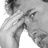

In [4]:
tf.keras.preprocessing.image.load_img("/content/fer2013/train/Angry/1000.jpg")

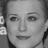

In [5]:
image = tf.keras.preprocessing.image.load_img("/content/fer2013/train/Happy/10.jpg")
image                  #returns PIL object

## Train and Test set

In [6]:
training_generator = ImageDataGenerator( rescale= 1./255,
                                                                      rotation_range = 7,
                                                                      horizontal_flip = True,
                                                                      zoom_range = 0.2)

In [7]:
train_dataset = training_generator.flow_from_directory("/content/fer2013/train",
                                                       target_size = (48,48),
                                                       batch_size = 16,
                                                       class_mode = 'categorical',
                                                       shuffle = True
                                                  )

Found 28709 images belonging to 7 classes.


In [8]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [9]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [10]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

<ipython-input-11-9991d005796b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = train_dataset.classes , palette='viridis')


<Axes: ylabel='count'>

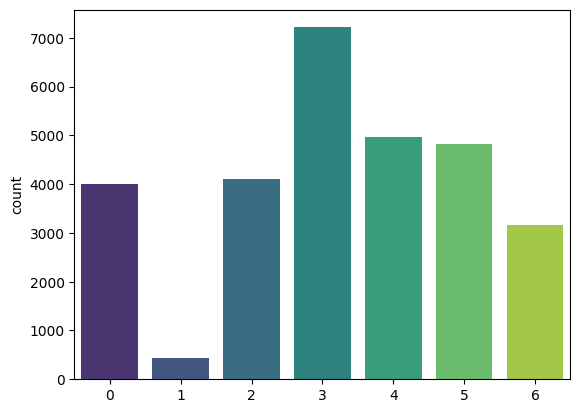

In [11]:
sns.countplot(x = train_dataset.classes , palette='viridis')

In [12]:
test_generator = ImageDataGenerator( rescale= 1./255)                                                                   # No new images need to be created by transformations
test_dataset = training_generator.flow_from_directory("/content/fer2013/validation",
                                                       target_size = (48,48),
                                                       batch_size = 1,
                                                       class_mode = 'categorical',
                                                       shuffle = False
                                                  )

Found 3589 images belonging to 7 classes.


## Building and training the CNN

In [13]:
num_detectors = 32
num_classes = 7
width , height = 48, 48
epochs = 100

network = Sequential()

network.add(Conv2D(num_detectors,(3,3), activation='relu',padding='same', input_shape=(width,height,3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))                           ## Implies not going to use 20% of the neurons to avoid overfitting

network.add(Conv2D(2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors,(3,3), activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2*num_detectors,activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2*num_detectors,activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes,activation='softmax'))
print(network.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,328,743 (5.07 MB)

 Trainable params: 1,326,567 (5.06 MB)

 Non-trainable params: 2,176 (8.50 KB)

None


In [14]:
network.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
network.fit(train_dataset,epochs=100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 776s 427ms/step - accuracy: 0.2236 - loss: 2.0121
Epoch 2/100
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 754s 420ms/step - accuracy: 0.3573 - loss: 1.6387
Epoch 3/100
1398/1795 ━━━━━━━━━━━━━━━━━━━━ 2:46 420ms/step - accuracy: 0.4574 - loss: 1.4091

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network,'/content/weights_emotions.hdf5')

In [14]:
with open('/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Weights/network_emotions.json','r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_8_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization_8", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0

In [15]:
from tensorflow.keras.models import model_from_json, Sequential

network_loaded = model_from_json(json_saved_model, custom_objects={'Sequential': Sequential})
network_loaded.load_weights('/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Weights/weights_emotions.hdf5')
network_loaded.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [16]:
network_loaded.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,328,743 (5.07 MB)

 Trainable params: 1,326,567 (5.06 MB)

 Non-trainable params: 2,176 (8.50 KB)

## Evaluate the neural network

In [17]:
network_loaded.evaluate(test_dataset)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3589/3589 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.5696 - loss: 1.3575


[1.5036463737487793, 0.5781554579734802]

In [19]:
predictions = network_loaded.predict(test_dataset)
predictions

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step


array([[6.22933388e-01, 9.46365669e-03, 1.74169585e-01, ...,
        1.06728755e-01, 7.33547881e-02, 1.06826592e-02],
       [9.36875284e-01, 1.06108011e-04, 5.11699878e-02, ...,
        6.04824920e-04, 2.35040230e-03, 3.95374846e-05],
       [9.58210647e-01, 7.86427176e-04, 2.14481726e-02, ...,
        1.93980662e-03, 3.17078573e-03, 6.30072958e-04],
       ...,
       [1.97280198e-03, 2.61153091e-05, 3.14924270e-02, ...,
        4.33937367e-03, 2.07925355e-03, 9.59200263e-01],
       [5.10529242e-03, 1.06574800e-04, 8.36637244e-02, ...,
        4.84045595e-01, 1.17238946e-02, 3.90312046e-01],
       [5.34558110e-03, 1.54855534e-05, 1.13264965e-02, ...,
        8.01390782e-03, 5.11682360e-03, 8.50209057e-01]], dtype=float32)

In [20]:
predictions = np.argmax(predictions,axis=1)
predictions

array([0, 0, 0, ..., 6, 4, 6])

In [21]:
test_dataset.classes  # Expected outputs

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.5739760378935637

In [23]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes,predictions)
type(cm)

numpy.ndarray

<Axes: >

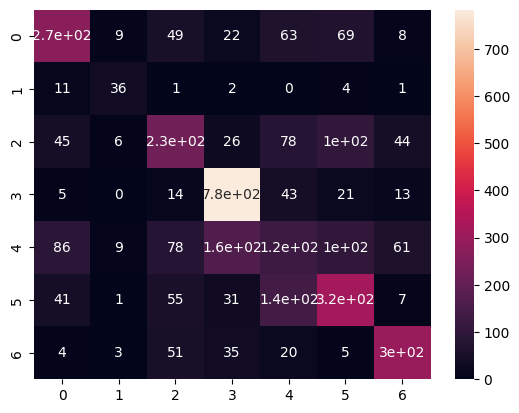

In [25]:
sns.heatmap(cm,annot=True)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes,predictions))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.43      0.45       528
           3       0.74      0.89      0.81       879
           4       0.27      0.20      0.23       626
           5       0.51      0.54      0.53       594
           6       0.69      0.72      0.70       416

    accuracy                           0.57      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.55      0.57      0.56      3589



## Classifying one single image

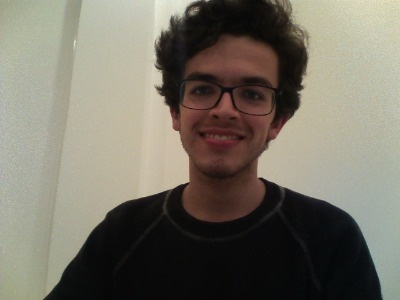

In [26]:
image = cv2.imread("/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Images/gabriel.png")
cv2_imshow(image)

In [27]:
image.shape

(300, 400, 3)

In [28]:
face_detector = cv2.CascadeClassifier("/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Cascades/haarcascade_frontalface_default.xml")

In [29]:
original_image = image.copy()
faces = face_detector.detectMultiScale(original_image)
faces

array([[162,  40, 128, 128]], dtype=int32)

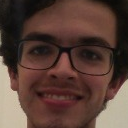

In [30]:
roi = image[40:40+128,162:162+128]
cv2_imshow(roi)

In [31]:
roi.shape

(128, 128, 3)

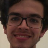

In [32]:
roi = cv2.resize(roi,(48,48))
cv2_imshow(roi)

In [33]:
roi = roi/255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [34]:
roi = np.expand_dims(roi,axis=0)
roi.shape

(1, 48, 48, 3)

In [35]:
probs = network_loaded.predict(roi)
probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


array([[5.2841834e-04, 1.1444097e-06, 1.2489497e-03, 8.9390194e-01,
        1.0206473e-01, 2.1787002e-03, 7.6220822e-05]], dtype=float32)

In [36]:
result = np.argmax(probs)
result

3

In [37]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## Classifying multiple images

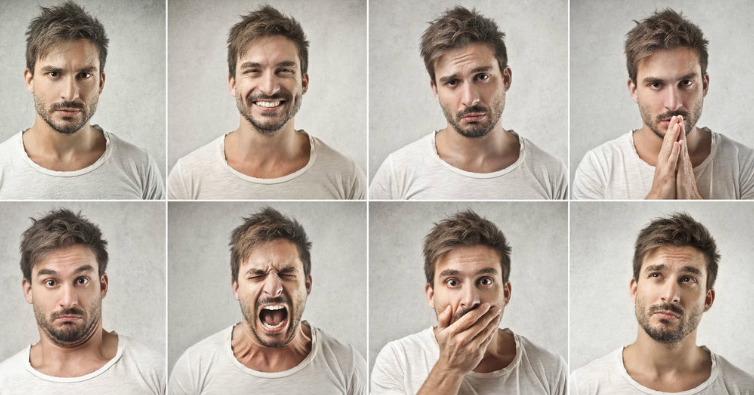

In [38]:
image = cv2.imread("/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Images/faces_emotions.png")
cv2_imshow(image)

In [39]:
faces = face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [40]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [30]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


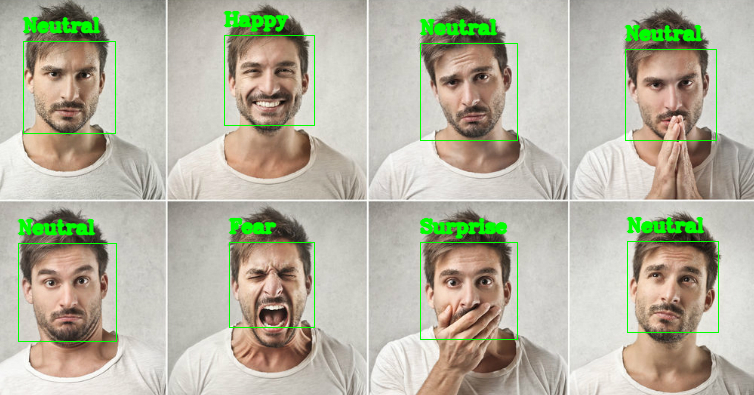

In [44]:
for (x,y,w,h) in faces:
  cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)
  roi = image[y: y+h , x:x+w]
  roi = cv2.resize(roi,(48,48))
  roi = roi / 255
  roi = np.expand_dims(roi,axis=0)
  # print(roi.shape)

  prediction = network_loaded.predict(roi)
  cv2.putText(image,emotions[np.argmax(prediction)],(x,y-10),cv2.FONT_HERSHEY_COMPLEX,0.6,(0,255,0),2,cv2.LINE_AA)

cv2_imshow(image)

## Classifying Emotions in videos

In [43]:
cap = cv2.VideoCapture("/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Videos/emotion_test01.mp4")
connected,video = cap.read()
print(connected,video.shape)

True (360, 640, 3)


In [44]:
save_path = "/content/drive/MyDrive/Computer Vision/Computer_Vision_MasterClass/Videos/etest_01_res.avi"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path,fourcc,fps,(video.shape[0],video.shape[1]))

In [45]:
import dlib
face_detector_hog = dlib.get_frontal_face_detector()
while (cv2.waitKey(1) < 0):
  connected,frame = cap.read()
  if not connected:
    break
  faces = face_detector_hog(frame,1)
  if len(faces) > 0:
      for face in faces:
            l = face.left()
            t = face.top()
            r = face.right()
            b = face.bottom()
            cv2.rectangle(frame,(l,t),(r,b),(0,255,255),2)
            roi = frame[t:b,l:r]
            roi = cv2.resize(roi,(48,48))
            roi = roi / 255
            roi = np.expand_dims(roi,axis = 0)
            prediction = network_loaded.predict(roi)

            if prediction is not None:
              result = np.argmax(prediction)
              cv2.putText(frame,emotions[np.argmax(prediction)],(l,t-10),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,255,0),2,cv2.LINE_AA)

      cv2_imshow(frame)
      output_video.write(frame)

      if cv2.waitKey(40) & 0xFF == ord('q'):
         break  # Stop when 'q' key is pressed


print('End')
output_video.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.